In [1]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [2]:
%matplotlib inline

In [3]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [4]:
device=t.device('cpu') #Overrride the above device choice

Generate the sample 2D distribution: uniform from unit circle.

In [5]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

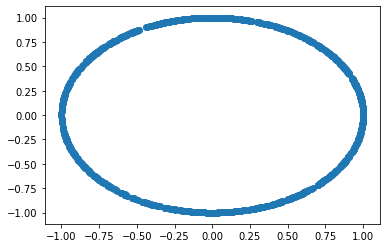

In [6]:
plt.scatter(data[:,0], data[:,1]);

In [7]:
def makeNet(n_layers, n_neurons_in_last_layer):
    n = n_layers-1
    n_neurons_in_first_layer = n_neurons_in_last_layer*(2**(n-1))
    modules=[]
    modules.append(Linear(in_features=2, out_features=n_neurons_in_first_layer)) #in_features=1 eksperymentowac; moze zostac1, w 2 problemie 2-3
    modules.append(LeakyReLU())
    for i in range(n-1):
        modules.append(Linear(in_features=n_neurons_in_first_layer, out_features=n_neurons_in_first_layer//2))
        modules.append(LeakyReLU())
        n_neurons_in_first_layer//=2
    modules.append(Linear(in_features=n_neurons_in_last_layer, out_features=2)) # 2 bo 2D, w dyskryminatorze to samo
   
    return Sequential(*modules)

In [8]:
data_t = t.from_numpy(data)

In [9]:
data_t

tensor([[ 0.7891,  0.6143],
        [-0.0327, -0.9995],
        [-0.6820, -0.7313],
        ...,
        [-0.8407, -0.5415],
        [ 0.9884, -0.1516],
        [-0.9910,  0.1338]])

In [10]:
# discriminator = Sequential(Linear(2,1),  Sigmoid()) #dummy discriminator: please subsitute you own implementation 
discriminator = Sequential(Linear(2,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                           Linear(32,1),  Sigmoid()
                                     )

In [11]:
discriminator = discriminator.to(device) 
data_t = data_t.to(device)

In [12]:
# generator = Sequential(Linear(1,2))# dummy generator: please subsitute you own implementation 
generator = makeNet(5,32)

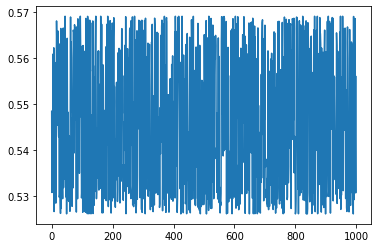

In [13]:
d_out = discriminator(data_t)
plt.plot(d_out.data.cpu().numpy())

In [14]:
generator= generator.to(device)

In [15]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));

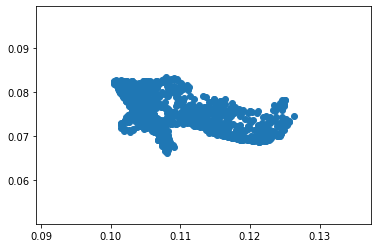

In [16]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [17]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [18]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

In [19]:
bce = t.nn.BCELoss()

In [20]:
mini_batch_size = 2048
k_discriminator = 4
k_generator = 1
for epoch in range(1,201):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
          
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size] #losowanie bach
            
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
      
            z = t.empty(mini_batch_size,1, device=device).uniform_(-1,1) #szum
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels) # ma dawac 0era
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
    #to samo dla generatora
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,2, device=device).uniform_(-1,1)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%5 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),2, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                
                print(epoch, d_loss.item(), g_loss.item())     

5 1.3817644119262695 0.6162954568862915
10 1.381791353225708 0.616272509098053
15 1.381800889968872 0.6162642240524292
20 1.3817946910858154 0.6162697076797485
25 1.3817942142486572 0.6162700057029724
30 1.3817856311798096 0.6162773370742798
35 1.3817923069000244 0.6162716150283813
40 1.3817753791809082 0.6162861585617065
45 1.3817837238311768 0.616279125213623
50 1.3817784786224365 0.6162834763526917
55 1.3817949295043945 0.6162694096565247
60 1.3817846775054932 0.6162780523300171
65 1.3817658424377441 0.6162943243980408
70 1.3817837238311768 0.6162790656089783
75 1.381797194480896 0.6162675619125366
80 1.3817858695983887 0.6162772178649902
85 1.3817744255065918 0.6162869334220886
90 1.3817903995513916 0.6162731647491455
95 1.3817777633666992 0.6162841320037842
100 1.381777286529541 0.6162844896316528
105 1.3817870616912842 0.6162762641906738
110 1.3817787170410156 0.6162832379341125
115 1.381779432296753 0.61628258228302
120 1.381798267364502 0.6162666082382202
125 1.3818010091781616

In [21]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));

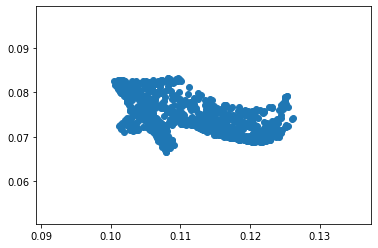

In [22]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.

Update to Pegaz both the notebook and the trained generator.

### Problem 2

Use sampling distribution below.

In [23]:
n_samples = 10000
a = 2
b = 1
angle2 = np.random.uniform(-np.pi,np.pi,(n_samples,1)).astype('float32')
r = np.sqrt(np.random.uniform(0.5,1,(n_samples,1)))
data2 = np.stack((a*r*np.cos(3*angle2), b*r*np.sin(2*angle2)),axis=1)

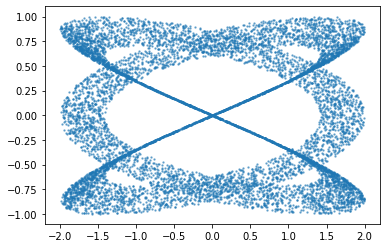

In [24]:
plt.scatter(data2[:,0], data2[:,1], s=2, alpha=0.5);

Update to Pegaz both the notebook and the trained generator.